In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
import shap
shap.initjs()


In [77]:
raw = pd.read_csv("bank-fulll.csv", header=None)  # header=None because the CSV is messy

# Step 2: Split the single column by ';'
df = raw[0].astype(str).str.split(";", expand=True)

# Step 3: Use first row as column names
df.columns = df.iloc[0].str.strip().str.replace('"','').str.replace("'",'')
df = df[1:]  # remove the row used as header
df.reset_index(drop=True, inplace=True)

# Step 4: Remove quotes from string columns
for col in df.columns:
    df[col] = df[col].astype(str).str.strip().str.replace('"','').str.replace("'",'')

# Step 5: Convert target column 'y' to 0/1
df['y'] = df['y'].map({'yes':1, 'no':0})

# Step 6: Check
print(df.columns.tolist())
print(df['y'].value_counts())


['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
y
0    39922
1     5289
Name: count, dtype: int64


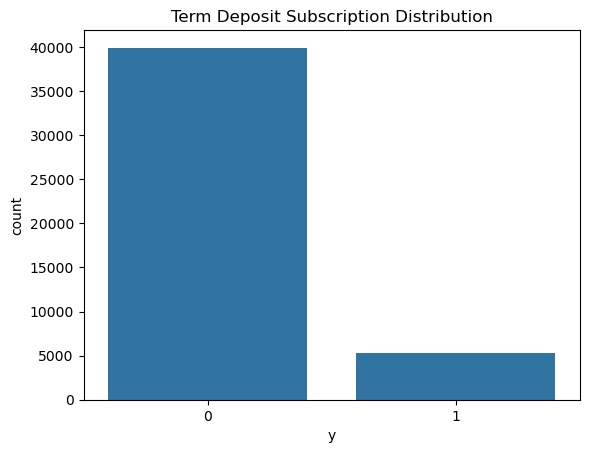

In [78]:
sns.countplot(x='y', data=df)
plt.title("Term Deposit Subscription Distribution")
plt.show()

In [79]:
le = LabelEncoder()

for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


In [80]:
X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [81]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("Logistic Regression F1 Score:", f1_score(y_test, y_pred_lr))


Logistic Regression F1 Score: 0.11004126547455295


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest F1 Score:", f1_score(y_test, y_pred_rf))


Random Forest F1 Score: 0.34204545454545454


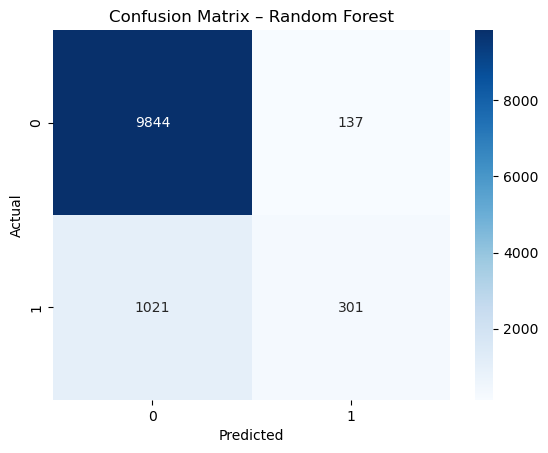

In [82]:
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


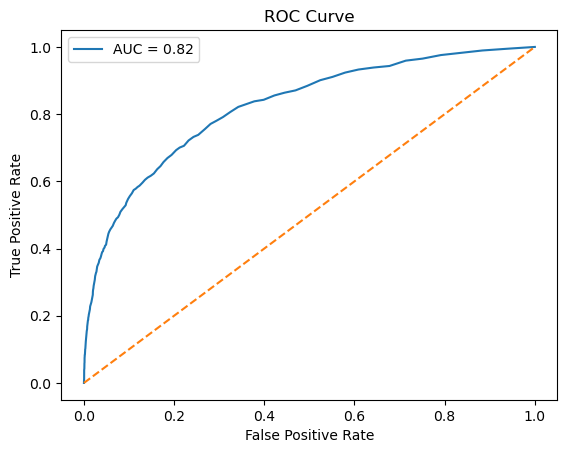

In [83]:
y_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [86]:

# Create explainer
explainer = shap.TreeExplainer(rf)

# Take first 5 test samples
X_sample = X_test.iloc[:5]

# Get SHAP values for all classes
shap_values = explainer.shap_values(X_sample)

# Force plot for class 1 (positive class)
shap.force_plot(
    explainer.expected_value[1],  # expected value for class 1
    shap_values[1],               # SHAP values for class 1
    X_sample                      # feature values
)


IndexError: index 5 is out of bounds for axis 0 with size 5

### Conclusion:
- Random Forest outperformed Logistic Regression
- Duration, balance, and previous campaign outcomes are key drivers
- SHAP explains individual customer predictions clearly
- Model can help banks optimize marketing strategies
